# Generate Frontiers for Single/Multiple models

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Pandas, Seaborn, Matplotlib modules.
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

### The cell given below sets up MATLAB for the notebook
Source: https://sehyoun.com/blog/20180904_using-matlab-with-jupyter-notebook.html

In [2]:
import matlab.engine
import io
import scipy.io
from IPython.core.magic import register_cell_magic
ip = get_ipython()

out = io.StringIO()
err = io.StringIO()

# Setup matlab cell magic #
@register_cell_magic
def matlab_magic(line,cell):
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.truncate(0)
    raw = '''{line}.eval("""{cell}""", nargout=0, stdout=out, stderr=err)'''
    ip.run_cell(raw.format(line=line, cell=cell))
    print(out.getvalue())
    print(err.getvalue())
    
# Starting a MATLAB engine called eng
eng = matlab.engine.start_matlab()

**Note:** Change this to the file path on your computer.

In [4]:
# Adds the MMB.m as well as MMBOPT1.m and MMBOPT2.m folders to the MATLAB engine path"
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2/MMB_OPTIONS', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/scripts', nargout=0)

# Important:
The code below sets the coefficients and other data for the PID rule to work.

Check out the coefficients table here:

https://github.com/rishab231/monetaryPolicy/blob/master/coefficients.png

In [5]:
# This sets the coefficients of the monetary policy rule, there are 33 coefficients and len(coefficients) = 33
coefficients = [0, 0, 0, 0, 1.5/4, 1.5/4, 1.5/4, 1.5/4, 
                0, 0, 0, 0, 0, 0.5, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 1, 0.25]

# Number of the model you want to chooose, please exclude 69-79, 19-22, 27, 59, 65, 68, 81, 97, 98
modelNum = 1

scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))

### Test run for MMB

In [6]:
eng.MMB(nargout = 0)

### Useful Functions

In [7]:
# Functions to get model name as well as the unconditional variances

def getModelName():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    return modelName

def unconditionalVariances():
    var4 = pd.read_csv("../mmb-gui-mlab-2.3.2/OUTPUT/variances.csv", names=["interest", "inflation", "outputgap", "output"])
    return var4

In [8]:
getModelName()

'NK_RW97'

In [9]:
unconditionalVariances()

,interest,inflation,outputgap,output
0,0.079687,0.06191,0.38901,1.1702


### PID Function

In [10]:
PID_loss_array = []
PID_final_inflation_variance = 0
PID_final_output_gap_variance = 0
PID_final_interest_rate_variance = 0
currentPIDLoss = 0

def myPID(selected_coeff, lambdaVal, coeffInterest, modelNum, VarTarget):
    global PID_final_inflation_variance
    global PID_final_output_gap_variance
    global PID_final_interest_rate_variance
    global currentPIDLoss

    coefficients = [1, 0, 0, 0, 
                    abs(selected_coeff[0])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    selected_coeff[1]/4, 
                    0, 0, 0, 0, 
                    selected_coeff[2], selected_coeff[3], 0, 
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.25]
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum)) # Input for MMB.
    eng.MMB(nargout = 0) # Run MMB
    
    variances = unconditionalVariances()
    
    interest_rate_variance = variances['interest'][0]
    inflation_variance = variances['inflation'][0]
    output_gap_variance = variances['outputgap'][0]
    
    PID_final_inflation_variance = inflation_variance
    PID_final_output_gap_variance = output_gap_variance
    PID_final_interest_rate_variance = interest_rate_variance
    
    PID_loss = ((interest_rate_variance - VarTarget[0])**2 * coeffInterest 
                + (inflation_variance / VarTarget[1]) * lambdaVal
                + (output_gap_variance/ VarTarget[2]) * (1 - lambdaVal) )
    
    print("myPID Loss", PID_loss, "lambda =", lambdaVal)
    PID_loss_array.append(PID_loss)
    currentPIDLoss = PID_loss
    
    return PID_loss

### Create frontier function which optimizes myPID as objective function

In [30]:
def createFrontier(modelNum):
    taylor_coeff = [1.5, 0, 0.5, 0] # Taylor rule coefficients.
    hamilton_coeff = [1.42, -1.20, 0.5, -0.48] # Hamilton fit coefficients.
    weights = np.arange(0, 1.01, .25) # Values for lambda
    interest_coeff = 1.0 # Coefficient on the interest_rate loss term
    
    # ---
    rVarTarget = [16.0, 1.0, 1.0] # # Normalizing coefficients for PID_loss (initial pass)
    mylambdatemp = 0.0 # Something to put in the lambda variable when calculating the target rate variance.
    # Run with Hamilton coefficients to generate target rate variance.
    myfoo = myPID(hamilton_coeff, mylambdatemp, interest_coeff, modelNum, rVarTarget)
    VarTarget = [unconditionalVariances()['interest'][0], 1, 1] # Normalizing variances for interest rate
    print("The target rate variances are", VarTarget[0]) # Print assigned rate variance.
    # ---
    
    PID_inflation_variances = []
    PID_output_gap_variances = []
    PID_interest_variances = []
    PID_loss_of_lambda = []
    PID_coefficients_array = []

    # Starting with the Taylor rule coefficients
    #current_coeff = taylor_coeff
    
    # Starting with the Hamilton rule coefficients
    current_coeff = hamilton_coeff

    for lambda_value in weights:
        PID_result = scipy.optimize.minimize(myPID, current_coeff, \
                                    args=(lambda_value, interest_coeff, modelNum, rVarTarget), method='Nelder-Mead')
        current_coeff = PID_result.x
        PID_coefficients_array.append(current_coeff)
        PID_inflation_variances.append(PID_final_inflation_variance)
        PID_output_gap_variances.append(PID_final_output_gap_variance)
        PID_interest_variances.append(PID_final_interest_rate_variance)
        PID_loss_of_lambda.append(currentPIDLoss)
    
    # The code below plots the frontier
    nameOfModel = getModelName()
    
    SD_inflation_scatter = np.sqrt(np.asarray(PID_inflation_variances))
    SD_output_gap_scatter = np.sqrt(np.asarray(PID_output_gap_variances))

    fig, ax = plt.subplots()
    ax.scatter(SD_inflation_scatter, SD_output_gap_scatter, color="red")

    for i in range(0, len(weights)):
        ax.annotate(weights[i], (SD_inflation_scatter[i], SD_output_gap_scatter[i]))

    ax.set_xlabel('$\sigma_{\pi}$', fontsize=10)
    ax.set_ylabel('$\sigma_{y}$', fontsize=10)
    ax.set_title('Policy Frontiers for Different Weights, Model: ' + nameOfModel, fontsize=14)
    saveFileName = nameOfModel + '.pdf'
    plt.savefig(saveFileName, bbox_inches='tight')
    
    # The code below saves the results of the all the optimizations with the appropriate lambdas into a DataFrame
    results = dict()
    results['lambdas'] = weights
    results['inflation_variance'] = PID_inflation_variances
    results['output_gap_variance'] = PID_output_gap_variances
    results['interest_variance'] = PID_interest_variances
    results['loss'] = PID_loss_of_lambda
    results['coefficients'] = PID_coefficients_array
    results_df = pd.DataFrame.from_dict(results)
    
    # Saving DataFrame to nameOfModel.csv file
    results_df.to_csv(nameOfModel + ".csv", index=False)
    
    return results_df

### A normalized version of the createFrontier function

In [31]:
def normalizedCreateFrontier(modelNum):
    taylor_coeff = [1.5, 0, 0.5, 0] # Taylor rule coefficients.
    hamilton_coeff = [1.42,-1.20,0.5,-0.48] # Hamilton fit coefficients.
    weights = np.arange(0, 1.01, .25) # Values for lambda
    interest_coeff = 1.0 # Coefficient on the interest_rate loss term (for constrained optimization)
    VarTarget = [16.0, 1.0, 1.0] # Normalizing coefficients for PID_loss on inital pass.
    
    mylambdatemp = 0.0 # Something to put in the lambda variable when calculating the target rate variance.
    myfoo = myPID(taylor_coeff, mylambdatemp, interest_coeff, modelNum, VarTarget) # Run with Hamilton coefficients to generate target rate variance.
    VarTarget[0] = unconditionalVariances()['interest'][0] # Normalizing variance for interest rate
    VarTarget[1] = unconditionalVariances()['inflation'][0] # Normalizing variance for inflation
    VarTarget[2] = unconditionalVariances()['outputgap'][0] # Normalizing variance for output gap
    print("The normalizing variances are", VarTarget) # Print normalizing variance.
    
    PID_inflation_variances = []
    PID_output_gap_variances = []
    PID_interest_variances = []
    PID_loss_of_lambda = []
    PID_coefficients_array = []
    
    # Starting with the Taylor rule coefficients
    current_coeff = taylor_coeff

    for lambda_value in weights:
        PID_result = scipy.optimize.minimize(myPID, current_coeff, \
                                    args=(lambda_value, interest_coeff, modelNum, VarTarget), method='Nelder-Mead')
        current_coeff = PID_result.x
        PID_coefficients_array.append(current_coeff)
        PID_inflation_variances.append(PID_final_inflation_variance)
        PID_output_gap_variances.append(PID_final_output_gap_variance)
        PID_interest_variances.append(PID_final_interest_rate_variance)
        PID_loss_of_lambda.append(currentPIDLoss)
    
    # The code below plots the frontier
    nameOfModel = getModelName()
    
    SD_inflation_scatter = np.asarray([np.sqrt(i) for i in PID_inflation_variances])
    SD_output_gap_scatter = np.asarray([np.sqrt(i) for i in PID_output_gap_variances])

    fig, ax = plt.subplots()
    ax.scatter(SD_inflation_scatter, SD_output_gap_scatter, color="red")

    for i in range(0, len(weights)):
        ax.annotate(weights[i], (SD_inflation_scatter[i], SD_output_gap_scatter[i]))

    ax.set_xlabel('$\sigma_{\pi}$', fontsize=10)
    ax.set_ylabel('$\sigma_{y}$', fontsize=10)
    ax.set_title('Policy Frontiers for Different Weights, Model: ' + nameOfModel, fontsize=14)
    saveFileName = nameOfModel + '.pdf'
    plt.savefig(saveFileName, bbox_inches='tight')
    
    # The code below saves the results of the all the optimizations with the appropriate lambdas into a DataFrame
    results = dict()
    results['lambdas'] = weights
    results['inflation_variance'] = PID_inflation_variances
    results['output_gap_variance'] = PID_output_gap_variances
    results['interest_variance'] = PID_interest_variances
    results['loss'] = PID_loss_of_lambda
    results['coefficients'] = PID_coefficients_array
    results_df = pd.DataFrame.from_dict(results)
    
    # Saving DataFrame to nameOfModel.csv file
    results_df.to_csv(str(modelNum) + "_" + nameOfModel + ".csv", index=False)
    
    return results_df

In [ ]:
# Model Number 15 - US FRB03
m15results = createFrontier(15)

Total PID Loss 95.195944 lambda = 0.0
The target rate variances are 22.712
Total PID Loss 95.195944 lambda = 0.0
Total PID Loss 94.11063600000003 lambda = 0.0
Total PID Loss 204.34187600000007 lambda = 0.0
Total PID Loss 59.523569 lambda = 0.0
Total PID Loss 217.61163600000006 lambda = 0.0
Total PID Loss 48.96712099999999 lambda = 0.0
Total PID Loss 37.605456 lambda = 0.0
Total PID Loss 51.322900000000004 lambda = 0.0
Total PID Loss 44.77368899999999 lambda = 0.0
Total PID Loss 34.554169000000016 lambda = 0.0
Total PID Loss 49.307216 lambda = 0.0
Total PID Loss 50.12727600000001 lambda = 0.0
Total PID Loss 39.98072899999999 lambda = 0.0
Total PID Loss 68.71452099999998 lambda = 0.0
Total PID Loss 39.029225000000004 lambda = 0.0
Total PID Loss 59.40322500000002 lambda = 0.0
Total PID Loss 37.381168999999986 lambda = 0.0
Total PID Loss 44.092023999999995 lambda = 0.0
Total PID Loss 35.516025000000006 lambda = 0.0
Total PID Loss 41.11124899999999 lambda = 0.0
Total PID Loss 35.71925599999

In [ ]:
m15resultsnorm = normalizedCreateFrontier(15)

# Section: Optimization across models/regions

In [13]:
PID_loss_array = []
PID_final_inflation_variance = 0
PID_final_output_gap_variance = 0
PID_final_interest_rate_variance = 0
currentPIDLoss = 0

# Without normalization
def multiplePID(selected_coeff, lambdaVal, coeffInterest, modelNums, normalizing_matrix):
    global PID_final_inflation_variance
    global PID_final_output_gap_variance
    global PID_final_interest_rate_variance
    global currentPIDLoss

    coefficients = [1, 0, 0, 0, 
                    abs(selected_coeff[0])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    selected_coeff[1]/4, 
                    0, 0, 0, 0, 
                    selected_coeff[2], selected_coeff[3], 0, 
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.25]
    
    # Initializing the PID loss to 0
    n = len(modelNums)
    weight = 1.0/n
    sumOfInterestVariances = 0
    sumOfInflationVariances = 0
    sumOfOutputGapVariances = 0
    
    # Running each model in modelNums
    for i in range(n):
        scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNums[i])) # Input for MMB.
        eng.MMB(nargout = 0) # Run MMB
        variances = unconditionalVariances()
        
        # Inverse weight each of these by Taylor variances to `normalize`
        interest_rate_variance = ((variances['interest'][0] - normalizing_matrix[i][0])/normalizing_matrix[i][0])**2
        inflation_variance = variances['inflation'][0]/normalizing_matrix[i][1]
        output_gap_variance = variances['outputgap'][0]/normalizing_matrix[i][2]
        
        sumOfInterestVariances += interest_rate_variance
        sumOfInflationVariances += inflation_variance
        sumOfOutputGapVariances += output_gap_variance
    
    PID_final_inflation_variance = 1.0/n * sumOfInflationVariances
    PID_final_output_gap_variance = 1.0/n * sumOfOutputGapVariances
    PID_final_interest_rate_variance = 1.0/n * sumOfInterestVariances
    
    PID_loss = ((PID_final_interest_rate_variance) * coeffInterest 
                + (PID_final_inflation_variance) * lambdaVal
                + (PID_final_output_gap_variance) * (1 - lambdaVal))
    
    print("Current PID Loss", PID_loss, "lambda =", lambdaVal)
    PID_loss_array.append(PID_loss)
    currentPIDLoss = PID_loss
    
    return PID_loss

In [14]:
def createGroupedFrontier(modelNums):
    taylor_coeff = [1.5, 0, 0.5, 0] # Taylor rule coefficients.
    hamilton_coeff = [1.42,-1.20,0.5,-0.48] # Hamilton fit coefficients.
    weights = np.arange(0, 1.01, .25) # Values for lambda
    interest_coeff = 1.0 # Coefficient on the interest_rate loss term (for constrained optimization)
    VarTarget = [16.0, 1.0, 1.0] # Normalizing coefficients for PID_loss on inital pass.
    
    normalizing_matrix = []
    mylambdatemp = 0.0 # Something to put in the lambda variable when calculating the target rate variance.
    
    for modelNum in modelNums:
        # Run with Taylor coefficients to generate target rate variance.
        myfoo = myPID(taylor_coeff, mylambdatemp, interest_coeff, modelNum, VarTarget)
        interest_m = unconditionalVariances()['interest'][0] # Normalizing variance for interest rate
        inflation_m = unconditionalVariances()['inflation'][0] # Normalizing variance for inflation
        output_gap_m = unconditionalVariances()['outputgap'][0] # Normalizing variance for output gap
        normalizing_matrix.append([interest_m, inflation_m, output_gap_m])
    
    PID_inflation_variances = []
    PID_output_gap_variances = []
    PID_interest_variances = []
    PID_loss_of_lambda = []
    PID_coefficients_array = []
    
    # Starting with the Taylor rule coefficients
    current_coeff = taylor_coeff

    for lambda_value in weights:
        PID_result = scipy.optimize.minimize(multiplePID, current_coeff, \
                                    args=(lambda_value, interest_coeff, modelNums, normalizing_matrix), method='Nelder-Mead')
        current_coeff = PID_result.x
        
        # Appending to the results
        PID_coefficients_array.append(current_coeff)
        PID_inflation_variances.append(PID_final_inflation_variance)
        PID_output_gap_variances.append(PID_final_output_gap_variance)
        PID_interest_variances.append(PID_final_interest_rate_variance)
        PID_loss_of_lambda.append(currentPIDLoss)
    
    # The code below plots the frontier
    modelNumbers = '_'.join(str(x) for x in modelNums)
    
    SD_inflation_scatter = np.asarray([np.sqrt(i) for i in PID_inflation_variances])
    SD_output_gap_scatter = np.asarray([np.sqrt(i) for i in PID_output_gap_variances])

    fig, ax = plt.subplots()
    ax.scatter(SD_inflation_scatter, SD_output_gap_scatter, color="red")

    for i in range(0, len(weights)):
        ax.annotate(weights[i], (SD_inflation_scatter[i], SD_output_gap_scatter[i]))

    ax.set_xlabel('$\sigma_{\pi}$', fontsize=10)
    ax.set_ylabel('$\sigma_{y}$', fontsize=10)
    ax.set_title('Policy Frontiers for Different Weights, Multiple Models: ' + modelNumbers, fontsize=14)
    saveFileName = "Multiple_" + modelNumbers + '.pdf'
    plt.savefig(saveFileName, bbox_inches='tight')
    
    # The code below saves the results of the all the optimizations with the appropriate lambdas into a DataFrame
    results = dict()
    results['lambdas'] = weights
    results['inflation_variance'] = PID_inflation_variances
    results['output_gap_variance'] = PID_output_gap_variances
    results['interest_variance'] = PID_interest_variances
    results['loss'] = PID_loss_of_lambda
    results['pi_t'] = [array[0] for array in PID_coefficients_array]
    results['pi_t-1'] = [array[1] for array in PID_coefficients_array]
    results['y_t'] = [array[2] for array in PID_coefficients_array]
    results['y_t-1'] = [array[3] for array in PID_coefficients_array]
    results_df = pd.DataFrame.from_dict(results)
    
    # Saving DataFrame to nameOfModel.csv file
    results_df.to_csv("Multiple_" + modelNumbers + ".csv", index=False)
    
    return results_df

### Generates a multiple model (grouped Frontier) for models 107, 108
To run the model please call `createGroupedFrontier` with a `list` of the required model numbers:

For example: `createGroupedFrontier([107, 108])`

After the optimization has completed, your folder (wherever this notebook Structured_Frontier is saved) should contain a pdf image eg. `Multiple_107_108.pdf` and a .csv file `Multiple_107_108.csv` with the results of the optimization.

myPID Loss 36770968.01 lambda = 0.0
myPID Loss 29729117.639999997 lambda = 0.0
Current PID Loss 1.0 lambda = 0.0
Current PID Loss 1.0137334293238116 lambda = 0.0
Current PID Loss 1.000014222474835 lambda = 0.0
Current PID Loss 0.9981391275275352 lambda = 0.0
Current PID Loss 0.9999337486780276 lambda = 0.0
Current PID Loss 1.001977519451962 lambda = 0.0
Current PID Loss 0.9971798333757138 lambda = 0.0
Current PID Loss 0.9976841965963403 lambda = 0.0
Current PID Loss 1.001237936033166 lambda = 0.0
Current PID Loss 0.9977401989538215 lambda = 0.0
Current PID Loss 1.0032449495716622 lambda = 0.0
Current PID Loss 0.9975595679503603 lambda = 0.0
Current PID Loss 0.99770507379051 lambda = 0.0
Current PID Loss 0.9972264381725131 lambda = 0.0
Current PID Loss 0.9998658611050272 lambda = 0.0
Current PID Loss 0.9969620431892837 lambda = 0.0
Current PID Loss 0.9971355976978025 lambda = 0.0
Current PID Loss 0.9971508244620254 lambda = 0.0
Current PID Loss 0.9968561510394288 lambda = 0.0
Current PI

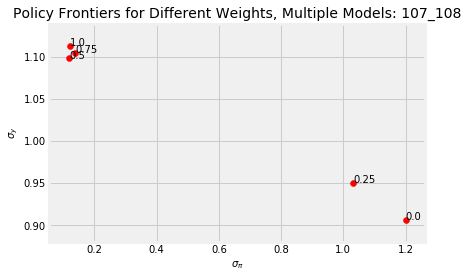

In [15]:
m_107_108_results = createGroupedFrontier([107, 108]) # Run